In [1]:
import xarray as xr
import numpy  as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.style import use as usestyle
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
from time import perf_counter
import xesmf
import cartopy.crs as ccrs
from cartopy import feature as cfeature
# import metpy as mpy
from pandas import date_range
from glob import glob
from pandas import date_range
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
from matplotlib import ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from astropy.convolution import convolve

In [2]:
# usestyle("paperplots.mplstyle")
from matplotlib import font_manager as fm
fontdir = "/home/ascheb/libfonts/*.ttf"
for fpath in glob(fontdir):
    print(fpath)
    fm.fontManager.addfont(fpath)

usestyle("paperplots.mplstyle")
from matplotlib import rcParams
rcParams["figure.titlesize"] = 20
rcParams["axes.titlesize"] = 16
rcParams["axes.labelsize"] = 16
rcParams["xtick.labelsize"] = 13
rcParams["ytick.labelsize"] = 13
rcParams["axes.linewidth"] = 0.4

/home/ascheb/libfonts/LiberationMono-BoldItalic.ttf
/home/ascheb/libfonts/LiberationSerif-Bold.ttf
/home/ascheb/libfonts/LiberationSans-BoldItalic.ttf
/home/ascheb/libfonts/LiberationSans-Regular.ttf
/home/ascheb/libfonts/LiberationMono-Italic.ttf
/home/ascheb/libfonts/LiberationMono-Bold.ttf
/home/ascheb/libfonts/LiberationMono-Regular.ttf
/home/ascheb/libfonts/LiberationSans-Italic.ttf
/home/ascheb/libfonts/LiberationSerif-BoldItalic.ttf
/home/ascheb/libfonts/LiberationSerif-Italic.ttf
/home/ascheb/libfonts/LiberationSans-Bold.ttf
/home/ascheb/libfonts/LiberationSerif-Regular.ttf


In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
def add_cartofeatures_snowbox(geoax):
    geoax.set_extent((controlgrid["x"][200], controlgrid["x"][750], controlgrid["y"][150], controlgrid["y"][650]), crs = ramscrs)
    # ax.annotate(axlabels[i], (0.04, 0.94), xycoords = "axes fraction", color = "black", fontsize = 6.5, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="dodgerblue", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    # ax.set_ylabel("Latitude")
    # ax.set_xlabel("Longitude")
    return ax

In [5]:
def add_cartofeatures_fulldomain(geoax):
    geoax.set_extent((controlgrid["x"].min(), controlgrid["x"].max(), controlgrid["y"].min(), controlgrid["y"].max()), crs = ramscrs)
    # ax.annotate(axlabels[i], (0.04, 0.94), xycoords = "axes fraction", color = "black", fontsize = 6.5, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    geoax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor = 'darkgrey', facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m', edgecolor = "black", facecolor = "none", linewidth = 0.4, zorder = 3))
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
    #                                             edgecolor='navy',
    #                                             facecolor="dodgerblue", linewidth = 0.2), zorder = 1)
    # ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', facecolor='none', scale = "50m", edgecolor='darkgrey', zorder = 2))
    geoax.add_feature(cfeature.NaturalEarthFeature(category="cultural", name = "admin_1_states_provinces_lakes", linewidth = 0.4, facecolor = "none", scale = "50m", edgecolor = "black", zorder = 3))
    
    gl = geoax.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
    gl.xlocator = mticker.FixedLocator([-83, -79, -75])
    gl.ylocator = mticker.FixedLocator([38, 40, 42, 44, 46])
    gl.bottom_labels = True
    gl.left_labels   = True
    gl.xlines = False
    gl.ylines = False
    gl.top_labels    = False
    gl.right_labels  = False
    gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
    # ax.set_ylabel("Latitude")
    # ax.set_xlabel("Longitude")
    return geoax

## Load Snowfall Data from CONTROL, VARTEMP, MORESNOW

In [6]:
control_snow_old = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_control/rams_output/a-A-2010-01-02-060000-g1.h5")
control_snow_new = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_control/rams_output/a-A-2010-01-03-060000-g1.h5")
vartemp_snow_old = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_vartemp/rams_output/a-A-2010-01-02-060000-g1.h5")
vartemp_snow_new = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_vartemp/rams_output/a-A-2010-01-03-060000-g1.h5")
moresnow_snow_old = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_moresnow/rams_output/a-A-2010-01-02-060000-g1.h5")
moresnow_snow_new = xr.open_dataset(f"/moonbow/ascheb/les/2010/hires_moresnow/rams_output/a-A-2010-01-03-060000-g1.h5")

In [7]:
snowdiff_control_vals = control_snow_new["ACCPS"]+control_snow_new["ACCPA"]-control_snow_old["ACCPS"]-control_snow_old["ACCPA"]
snowdiff_vartemp_vals = vartemp_snow_new["ACCPS"]+vartemp_snow_new["ACCPA"]-vartemp_snow_old["ACCPS"]-vartemp_snow_old["ACCPA"]
snowdiff_moresnow_vals = moresnow_snow_new["ACCPS"]+moresnow_snow_new["ACCPA"]-moresnow_snow_old["ACCPS"]-moresnow_snow_old["ACCPA"]
# snowdiff_vartemp = snowdiff_varetemp; del snowdiff_varetemp
snowdiff_control_vals = snowdiff_control_vals[1:-1,1:-1].values
snowdiff_vartemp_vals = snowdiff_vartemp_vals[1:-1,1:-1].values
snowdiff_moresnow_vals = snowdiff_moresnow_vals[1:-1,1:-1].values

In [8]:
controlgrid = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/gridconsts.nc")

In [9]:
snowdiff_control = xr.DataArray(snowdiff_control_vals, coords = {"y": controlgrid["y"], "x": controlgrid["x"]}, dims = ["y", "x"])
snowdiff_vartemp = xr.DataArray(snowdiff_vartemp_vals, coords = {"y": controlgrid["y"], "x": controlgrid["x"]}, dims = ["y", "x"])
snowdiff_moresnow = xr.DataArray(snowdiff_moresnow_vals, coords = {"y": controlgrid["y"], "x": controlgrid["x"]}, dims = ["y", "x"])

## Make Boxes and Compare Snowfall

In [10]:
ix0 = 400; iy0 = 525 #Northwest side of the "downwind of lake erie" box, at the center of the downwind shore
x0 = controlgrid["x"].isel(x = ix0); y0 = controlgrid["y"].isel(y = iy0); dxy = np.diff(controlgrid["x"])[0]
width = 400000; length = 305000 #m, dimensions of the box
tarray = np.arange(0, length+1, dxy); narray = np.arange(-width/2, width/2+1, dxy) #Coordinates of the box in tangent (long-axis) and normal (short-axis) directions. Normal is negative and positive (northeast and southwest), while tangent is only positive (to the right)
tmesh, nmesh = np.meshgrid(tarray, narray)
print(tmesh)
print(nmesh)
angle = np.pi/180*(-60) #Angle of the long axis of the box, with respect to the horizontal
xbox = x0.values+np.cos(angle)*tmesh-np.sin(angle)*nmesh
ybox = y0.values+np.sin(angle)*tmesh+np.cos(angle)*nmesh
snowbox = xr.DataArray(coords = {"y": (("normal", "tangent"), ybox), "x": (("normal", "tangent"), xbox), "normal": narray, "tangent": tarray}, dims = ["normal", "tangent"])

downwindsnow_control = snowdiff_control.interp(x = snowbox["x"], y = snowbox["y"])
downwindsnow_vartemp = snowdiff_vartemp.interp(x = snowbox["x"], y = snowbox["y"])
downwindsnow_moresnow = snowdiff_moresnow.interp(x = snowbox["x"], y = snowbox["y"])

print("Total Snow:", downwindsnow_control.mean(), downwindsnow_vartemp.mean(), downwindsnow_moresnow.mean(), downwindsnow_control.mean()/downwindsnow_vartemp.mean(), downwindsnow_control.mean()/downwindsnow_moresnow.mean())


patchpoints = np.zeros((4, 2))
patchpoints[:,0] = [downwindsnow_control["x"].values[0,0], downwindsnow_control["x"].values[0, -1], downwindsnow_control["x"].values[-1, -1], downwindsnow_control["x"].values[-1, 0]]
patchpoints[:,1] = [downwindsnow_control["y"].values[0,0], downwindsnow_control["y"].values[0, -1], downwindsnow_control["y"].values[-1, -1], downwindsnow_control["y"].values[-1, 0]]

print("Main Band:", downwindsnow_control[210:250, 0:100].mean(), downwindsnow_vartemp[210:250, 0:100].mean(), downwindsnow_moresnow[210:250, 0:100].mean(), downwindsnow_control[210:250, 0:100].sum()/downwindsnow_vartemp[210:250, 0:100].sum(), downwindsnow_control[210:250, 0:100].sum()/downwindsnow_moresnow[210:250, 0:100].sum()) #Change in snowfall in main band
#Points 210:250, 0:100 form a rectangle roughly bounding the main snow band over Lake Erie in the CONTROL simulation
patchpointssub = np.zeros((4, 2)) #These are the points for box B in the figure below, outlining the main band
patchpointssub[:,0] = [downwindsnow_control["x"].values[210,0], downwindsnow_control["x"].values[210, 100], downwindsnow_control["x"].values[250, 100], downwindsnow_control["x"].values[250, 0]]
patchpointssub[:,1] = [downwindsnow_control["y"].values[210,0], downwindsnow_control["y"].values[210, 100], downwindsnow_control["y"].values[250, 100], downwindsnow_control["y"].values[250, 0]]
# print(downwindsnow_control[210:250, 0:100].mean(), downwindsnow_nolake[210:250, 0:100].mean(), downwindsnow_control[210:250, 0:100].sum()/downwindsnow_nolake[210:250, 0:100].sum())

print("NE:", downwindsnow_control[350:400, 0:100].mean(), downwindsnow_vartemp[350:400, 0:100].mean(), downwindsnow_moresnow[350:400, 0:100].mean(), downwindsnow_control[350:400, 0:100].sum()/downwindsnow_vartemp[350:400, 0:100].sum(), downwindsnow_control[350:400, 0:100].sum()/downwindsnow_moresnow[350:400, 0:100].sum()) #Change in snowfall in main band
#Points 210:250, 0:100 form a rectangle roughly bounding the main snow band over Lake Erie in the CONTROL simulation
patchpointsne = np.zeros((4,2)) #Points bounding the band in northeast Lake Erie (box D)
patchpointsne[:,0] = [downwindsnow_control["x"].values[350,0], downwindsnow_control["x"].values[350, 100], downwindsnow_control["x"].values[400, 100], downwindsnow_control["x"].values[400, 0]]
patchpointsne[:,1] = [downwindsnow_control["y"].values[350,0], downwindsnow_control["y"].values[350, 100], downwindsnow_control["y"].values[400, 100], downwindsnow_control["y"].values[400, 0]]


patchpoints_between = np.zeros((4, 2)) #Points bounding area downwind of Lake Erie between box B and box D (box C)
patchpoints_between[:,0] = [downwindsnow_control["x"].values[250,0], downwindsnow_control["x"].values[250, 100], downwindsnow_control["x"].values[350, 100], downwindsnow_control["x"].values[350, 0]]
patchpoints_between[:,1] = [downwindsnow_control["y"].values[250,0], downwindsnow_control["y"].values[250, 100], downwindsnow_control["y"].values[350, 100], downwindsnow_control["y"].values[350, 0]]

# laurelindices = np.argwhere((control_snow_old["lat2d"].values>39.72)*(control_snow_old["lat2d"].values<40.4)*(control_snow_old["lon2d"].values>-79.8)*(control_snow_old["lon2d"].values<-78.65)) #Rectangle roughly covering the laurel highlands
# print(laurelindices)
# laurelpatchpoints = np.zeros((4,2))
# laurelpatchpoints[:,0] = [control_snow_old["x"].values[laurelindices[:,1].min()], control_snow_old["x"].values[laurelindices[:,1].max()], control_snow_old["x"].values[laurelindices[:,1].max()], control_snow_old["x"].values[laurelindices[:,1].min()]]
# laurelpatchpoints[:,1] = [control_snow_old["y"].values[laurelindices[:,0].min()], control_snow_old["y"].values[laurelindices[:,0].min()], control_snow_old["y"].values[laurelindices[:,0].max()], control_snow_old["y"].values[laurelindices[:,0].max()]]
# print(laurelpatchpoints) #Show this rectangle on the snowfall difference plot as box E
# laurelpatchcenter = [np.mean(laurelpatchpoints[:,0]), np.mean(laurelpatchpoints[:,1])]
# print(snowdiff_control.isel(y = slice(laurelindices[:,0].min(), laurelindices[:,0].max()), x = slice(laurelindices[:,1].min(), laurelindices[:,1].max())).mean()) #CONTROL simulation snowfall over the laurel highlands
# print(snowdiff_nolake.isel(y = slice(laurelindices[:,0].min(), laurelindices[:,0].max()), x = slice(laurelindices[:,1].min(), laurelindices[:,1].max())).mean()) #NLH simulation snowfall over the laurel highlands

[[     0.   1000.   2000. ... 303000. 304000. 305000.]
 [     0.   1000.   2000. ... 303000. 304000. 305000.]
 [     0.   1000.   2000. ... 303000. 304000. 305000.]
 ...
 [     0.   1000.   2000. ... 303000. 304000. 305000.]
 [     0.   1000.   2000. ... 303000. 304000. 305000.]
 [     0.   1000.   2000. ... 303000. 304000. 305000.]]
[[-200000. -200000. -200000. ... -200000. -200000. -200000.]
 [-199000. -199000. -199000. ... -199000. -199000. -199000.]
 [-198000. -198000. -198000. ... -198000. -198000. -198000.]
 ...
 [ 198000.  198000.  198000. ...  198000.  198000.  198000.]
 [ 199000.  199000.  199000. ...  199000.  199000.  199000.]
 [ 200000.  200000.  200000. ...  200000.  200000.  200000.]]
Total Snow: <xarray.DataArray ()>
array(1.87139324) <xarray.DataArray ()>
array(1.78699543) <xarray.DataArray ()>
array(1.87516137) <xarray.DataArray ()>
array(1.04722889) <xarray.DataArray ()>
array(0.99799051)
Main Band: <xarray.DataArray ()>
array(8.70520571) <xarray.DataArray ()>
array(7

## Plot Comparison of Snowfall Between CONTROL, VARTEMP, and MORESNOW

2010-01-02 06:00:00
2010-01-03 06:00:00


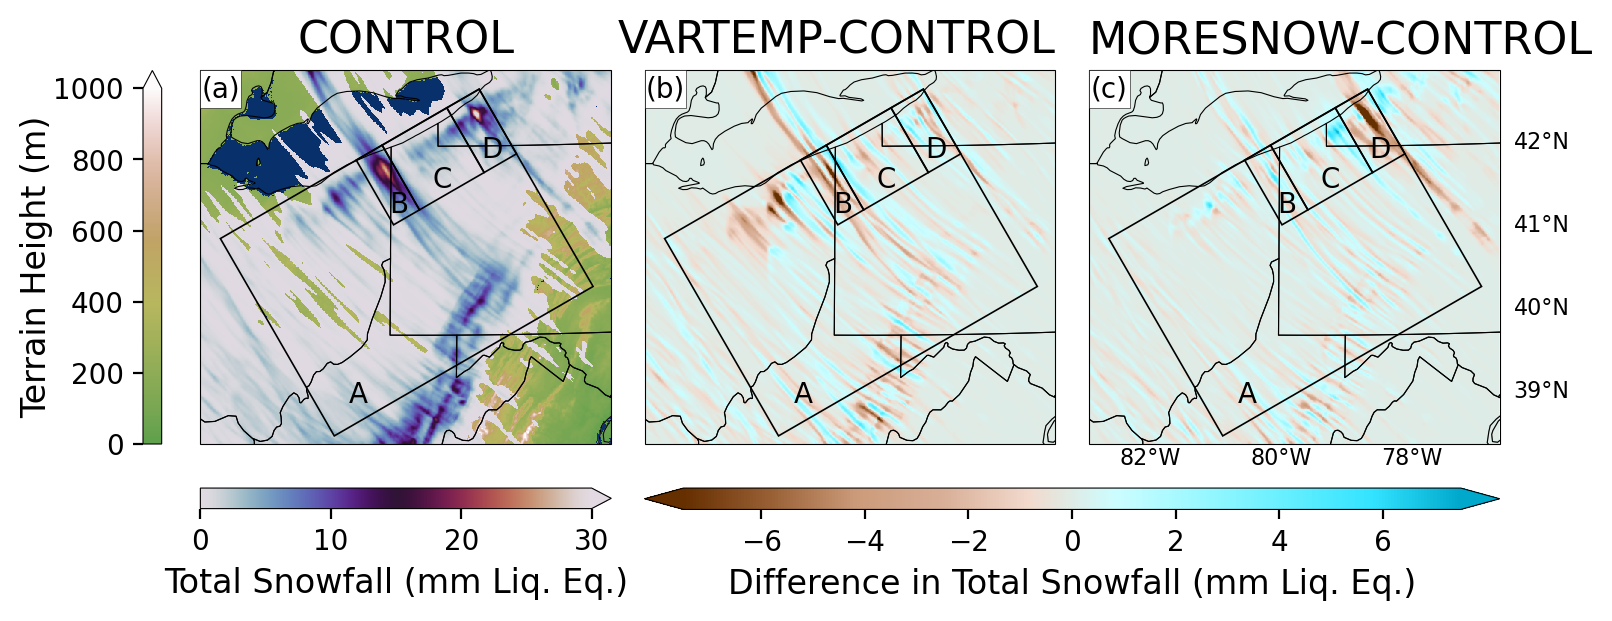

In [14]:
ramscrs = ccrs.Stereographic(central_longitude = -80, central_latitude = 42)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3, figsize = (8.1, 3), dpi = 200, layout = "compressed", subplot_kw = {"projection": ramscrs})
startt = datetime(2010, 1, 2, 6, 0, 0); print(startt)
endt = datetime(2010, 1, 3, 6, 0, 0); print(endt)
modtopocmap = truncate_colormap(mpl.colormaps.get_cmap("gist_earth"), minval = 0.5, maxval = 1, n = 128)
axlabelsbot = ["(a)", "(b)", "(c)"]
from palettable.lightbartlein.diverging import BrownBlue10_10
snwdiffcmap = BrownBlue10_10.get_mpl_colormap()
for i, ax in enumerate((ax11, ax12, ax13)):
    ax = add_cartofeatures_snowbox(ax)
    left, width = 0, 0.1
    bottom, height = 0.90, 0.1
    right = left + width
    top = bottom + height
    p = plt.Rectangle((left, bottom), width, height, fill=True, zorder = 3, edgecolor = "black", linewidth = 0.2, facecolor = "white")
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(left+0.5*width, bottom+0.5*height, axlabelsbot[i], fontsize = 10, transform = ax.transAxes, horizontalalignment = "center", verticalalignment = "center")
    ax.add_patch(mpl.patches.Polygon(patchpoints, edgecolor = "black", facecolor = [1, 0, 0, 0], linewidth = 0.6, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpointssub, edgecolor = "black", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpointsne, edgecolor = "black", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
    # ax.add_patch(mpl.patches.Polygon(laurelpatchpoints, edgecolor = "black", facecolor = [1,0, 0, 0], linewidth = 0.6, zorder = 3, transform = ramscrs))
    ax.add_patch(mpl.patches.Polygon(patchpoints_between, edgecolor = "black", facecolor = [1,0,0,0], linewidth = 0.6, zorder = 3, transform = ramscrs))
    ax.annotate("A", [-81, 39], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("B", [-80.4, 41.3], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("C", [-79.7, 41.6], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    ax.annotate("D", [-78.9, 41.95], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())
    # ax.annotate("E", [-79, 39.9], horizontalalignment = "center", verticalalignment = "center", fontsize = 8, color = "black", transform = ccrs.PlateCarree())
gl = ax13.gridlines(crs = ccrs.PlateCarree(), draw_labels = {"bottom": "x", "left": "y"}, x_inline = False, y_inline = False, dms = True)
gl.xlocator = mticker.FixedLocator([-82, -80, -78])
gl.ylocator = mticker.FixedLocator([38, 39, 40, 41, 42])
gl.bottom_labels = True
gl.left_labels   = False
gl.xlines = False
gl.ylines = False
gl.top_labels    = False
gl.right_labels  = True
gl.xlabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
gl.ylabel_style = {'size': 8, 'color': 'black', 'rotation': 0, "horizontalalignment": "right"}
termp = ax11.pcolormesh(controlgrid["x"], controlgrid["y"], controlgrid["Topo"], cmap = modtopocmap, vmin = 0, vmax = 1000, zorder = 0, transform = ramscrs)

#Because of the heavy snow in Region B in CONTROL (leading to dark red in ax21), we need to plot in white there instead of black
# ax11.annotate("B", [-80.4, 41.3], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "white", transform = ccrs.PlateCarree())
# ax13.annotate("B", [-80.4, 41.3], horizontalalignment = "center", verticalalignment = "center", fontsize = 10, color = "black", transform = ccrs.PlateCarree())

    # ax.pcolormesh(afile_control["lon1d"], afile_control["lat1d"], afile_control["Patch"][0,:,:].where(afile_control["Patch"][0,:,:]==1), color = "Navy", zorder = 0)
ax11.set_title("CONTROL")
ax12.set_title("VARTEMP-CONTROL", loc = "right")
ax13.set_title("MORESNOW-CONTROL", loc = "left")
# fig.suptitle(f"24-Hour Snowfall Ending {(endt).strftime('%d')} Jan - {(endt).strftime('%H%M')} UTC", y = 0.96)
# # # ax1.contour(afile_control["lon1d"], afile_control["lat1d"], afile_control["Patch"][1,:,:], levels = [0.999], colors = "white", linestyles = "-", linewidths = 0.7)
# # # ax1.legend(loc = "lower left", fontsize = 20, handles = [fakecontour])
# # # ax2.contour(afile_control["lon1d"], afile_control["lat1d"], afile_nolake["Patch"][1,:,:], levels = [0.999], colors = "white", linestyles = "-", linewidths = 0.7)
# # # ax2.legend(loc = "lower left", fontsize = 20, handles = [fakecontour])
ax11.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], controlgrid["Patch"][0,150:650,200:750].where(controlgrid["Patch"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax12.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], controlgrid["Patch"][0,150:650,200:750].where(controlgrid["Patch"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
ax13.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], controlgrid["Patch"][0,150:650,200:750].where(controlgrid["Patch"][0,150:650,200:750]>0.01), vmin = 0, vmax = 0.1, cmap = "Blues", shading = "nearest", zorder = 1, transform = ramscrs)
snowmp = ax11.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], snowdiff_control[150:650,200:750].where(snowdiff_control[150:650,200:750]>0.1), shading = "nearest", cmap = "twilight", vmin = 0, vmax = 30, zorder = 2, transform = ramscrs)
snwdiffmp = ax12.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], (snowdiff_vartemp[150:650,200:750]-snowdiff_control[150:650,200:750]), shading = "nearest", cmap = snwdiffcmap, vmin = -7.5, vmax = 7.5, zorder = 2, transform = ramscrs)
ax13.pcolormesh(controlgrid["x"][200:750], controlgrid["y"][150:650], (snowdiff_moresnow[150:650,200:750]-snowdiff_control[150:650,200:750]), shading = "nearest", cmap = snwdiffcmap, vmin = -7.5, vmax = 7.5, zorder = 2, transform = ramscrs)
fig.get_layout_engine().set(w_pad = 6/72, h_pad = 3/72, wspace = 0.05, hspace = 0)

snowcbar = fig.colorbar(snowmp, ax = [ax11], orientation = "horizontal", fraction = 0.1, extend = "max", pad = 0.05); snowcbar.set_label("Total Snowfall (mm Liq. Eq.)", fontsize = 12)
snwdiffcbar = fig.colorbar(snwdiffmp, ax = [ax12, ax13], orientation = "horizontal", fraction = 0.1, extend = "both", pad = 0.05, aspect = 40); snwdiffcbar.set_label("Difference in Total Snowfall (mm Liq. Eq.)", fontsize = 12)
tercbar = fig.colorbar(termp, ax = [ax11, ax12, ax13], orientation = "vertical", location = "left", fraction = 0.1, extend = "max", pad = 0.02); tercbar.set_label("Terrain Height (m)", fontsize = 12, labelpad = 0.02)
for cbari in [snowcbar, snwdiffcbar, tercbar]:
    cbari.ax.tick_params(labelsize = 10)
fig.savefig(f"../PaperFigs/SnowTotSensitivity_{endt.strftime('%d%H%M')}z_V2.png")
# plt.close();
# del ax11; del ax12; del ax13
# del fig; del snowcbar; del tercbar;
# del snowmp; del termp